# Hipótesis 2

### "Existe una relación entre el porcentaje de viviendas de bajo consumo o esporádicas, de viviendas de consumo medio y de viviendas de alto consumo de una provincia y su tendencia a adoptar dispositivos de energía renovable"

Las viviendas de bajo consumo o esporádicas suelen corresponder a residencias secundarias, utilizadas principalmente durante periodos vacacionales o de forma ocasional. Debido a esto, las provincias con mayor porcentaje de este tipo de residencias suelen tener menor tendencia a adquirir dispositivos de energías renovables debido al poco tiempo que sus propietarios pasan en ellas.

Por otro lado, en las viviendas de alto consumo, sus propietarios suelen tener un poder adquisitivo mayor, y generalmente, prefieren contratar la electricidad a lidiar con los posibles problemas técnicos de este tipo de instalaciones.

Por último, las viviendas de consumo medio representan un equilibrio entre los costes y beneficios de las energías renovables. Por ello, la instalación de dispositivos de energía renovable puede ser una opción atractiva para los propietarios, ya que permite reducir gastos energéticos de manera significativa a medio y largo plazo.

<hr style="border: none; border-top: 1px solid #ccc;" />

### Preparación del entorno

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os
import scipy
import seaborn as sns

GOLD_DATA_PATH = os.path.join("..","..","data","gold")

<hr style="border: none; border-top: 1px solid #ccc;" />

### Datos

In [92]:
h2_df = pd.read_csv(os.path.join(GOLD_DATA_PATH, "data_card_2_df.csv"), sep = ";", encoding='latin')
h2_df.head()

,Provincias,Indice de viviendas renovables,Indice de viviendas bajo consumo,Indice de viviendas medio consumo,Indice de viviendas alto consumo
0,Albacete,4.314062,16.455392,49.556800,3.410094
1,Alicante/Alacant,4.036060,17.315108,46.869125,4.043834
2,Almería,6.713842,14.252022,47.126887,4.279526
3,Araba/Álava,10.445424,14.195114,65.471842,1.313018
4,Asturias,5.031368,15.586008,52.933971,2.967485


A continuación, calculamos las correlaciones entre las distintas variables del dataframe.

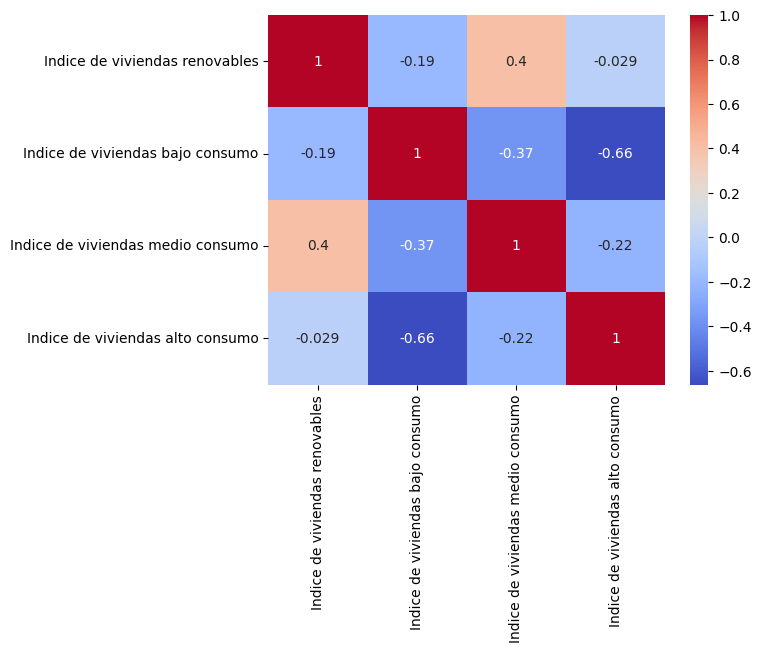

In [93]:
# Eliminar la columna provincias
h2_df_corr = h2_df.drop(columns=['Provincias'])

corr_matrix = h2_df_corr.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

Una vez mostradas las correlaciones entre variables a través de una matriz de correlación, se puede llegar a las siguientes conclusiones:

- Existe una alta correlación negativa entre el **ìndice de viviendas de bajo consumo** y el **índice de viviendas de alto consumo**. 

- Existe una pequeña correlación (0.4) entre el **índice de viviendas de medio consumo** y el **índice de viviendas con algún dispositivo de energía renovable**.

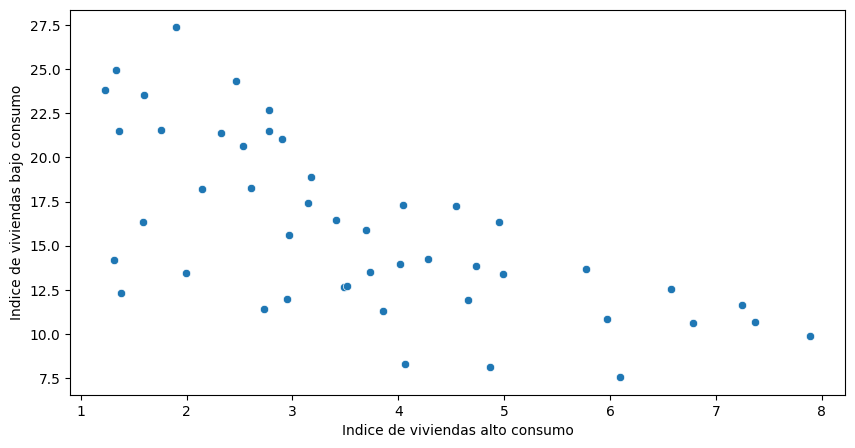

In [94]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Indice de viviendas alto consumo', y='Indice de viviendas bajo consumo', data=h2_df)
plt.show()

Con este gráfico se quiere visualizar la relación entre el **ìndice de viviendas de bajo consumo** y el **índice de viviendas de alto consumo** debido a su alta correlación.

<hr style="border: none; border-top: 1px solid #ccc;" />

### Clustering

En este paso, vamos a hacer un clustering con K-Means. Se ha decidido utilizar este tipo de clustering debido a los siguientes motivos:

- **Facilidad de interpretación**: Este tipo de clustering es más fácil de interpretar. A diferencia del clustering jerárquico, no tenemos que analizar la estructura de ramificación de los dendogramas, lo que facilita el entendimiento.

- **Exploración de datos**: El clustering normalmente no se suele usar como validación de hipótesis, sino que, su objetivo es explorar los datos, identificar patrones e intentar obtener datos útiles mediante la interpretación de este. Se ha decidido utilizar `K-means`debido a su simplicidad, no solo de interpretar resultados, sino que también de obtener el número óptimo de clusters mediante el método del codo.

In [95]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

Debido a que la *escala* de cada una de las características utilizadas en el clustering es ligeramente distinta, se ha decidido utilizar un `StandardScaler`.

Según la documentación oficial de `sklearn`, este scaler transforma los datos para que tengan media 0 y desviación típica 1.

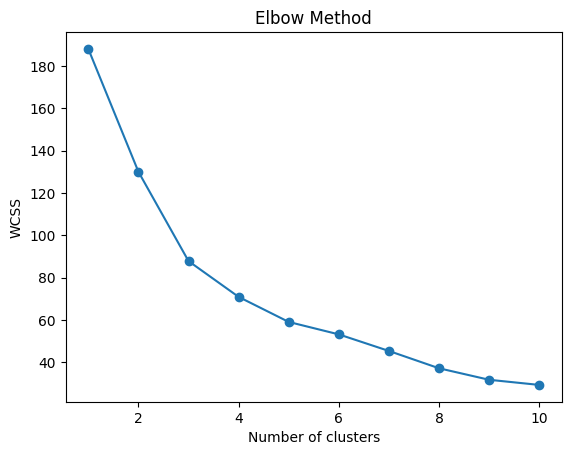

In [96]:
X = h2_df.drop(columns=['Provincias'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')    
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Mediante el metodo del codo, interpretamos que el número óptimo de clusters es 3.

In [97]:
k = 3

kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_scaled)

h2_df['Cluster'] = kmeans.labels_
h2_df['Cluster'] = h2_df['Cluster'].astype('category')

# Visualizacion 3D de los clusters
from plotly import express as px

fig = px.scatter_3d(
    h2_df, x='Indice de viviendas alto consumo', y='Indice de viviendas bajo consumo', z='Indice de viviendas medio consumo',
    color='Cluster', color_continuous_scale='viridis',
    title='Clusters de consumo de viviendas',
    labels={'Indice de viviendas alto consumo': 'Alto consumo', 'Indice de viviendas bajo consumo': 'Bajo consumo', 'Indice de viviendas medio consumo': 'Medio consumo'},
    hover_data={'Provincias': True}
)
fig.show()

Se muestran los distintos clusters obtenidos mediante `K-means` en un gráfico tridimensional en el que los ejes son el índice de viviendas de bajo, medio y alto consumo.

Para entender mejor los grupos realizados, se muestra en un mapa.

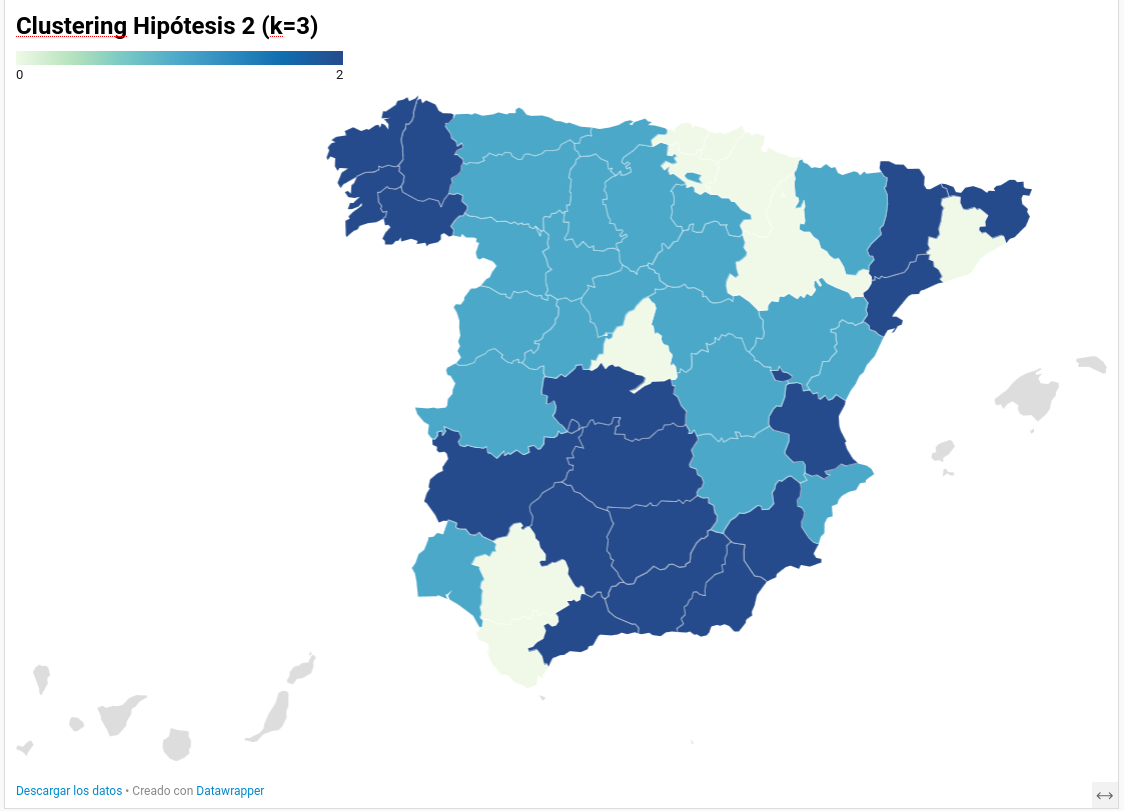

In [98]:
h2_df_cluster = h2_df.copy()
h2_df_cluster.drop(columns=['Indice de viviendas renovables', 'Indice de viviendas bajo consumo','Indice de viviendas medio consumo','Indice de viviendas alto consumo' ], inplace=True)

Se almacena los clusters obtenidos mediante el algoritmo de clustering con `K-means` para poder exportarlo a *[Datawrapper](https://app.datawrapper.de/)*, que es la aplicación web utilizada para generar los mapas.

In [ ]:
h2_df_cluster.to_csv("k_means_cluster_h2.csv", sep = ";", index=False, encoding='utf-8')

Posteriormente, se muestra gráficamente a través de un *boxplot*, los valores para cada característica que se quiere estudiar: **índice de viviendas renovables**, **índice de viviendas de bajo consumo**, **índice de viviendas de medio consumo** y **índice de viviendas de alto consumo**.

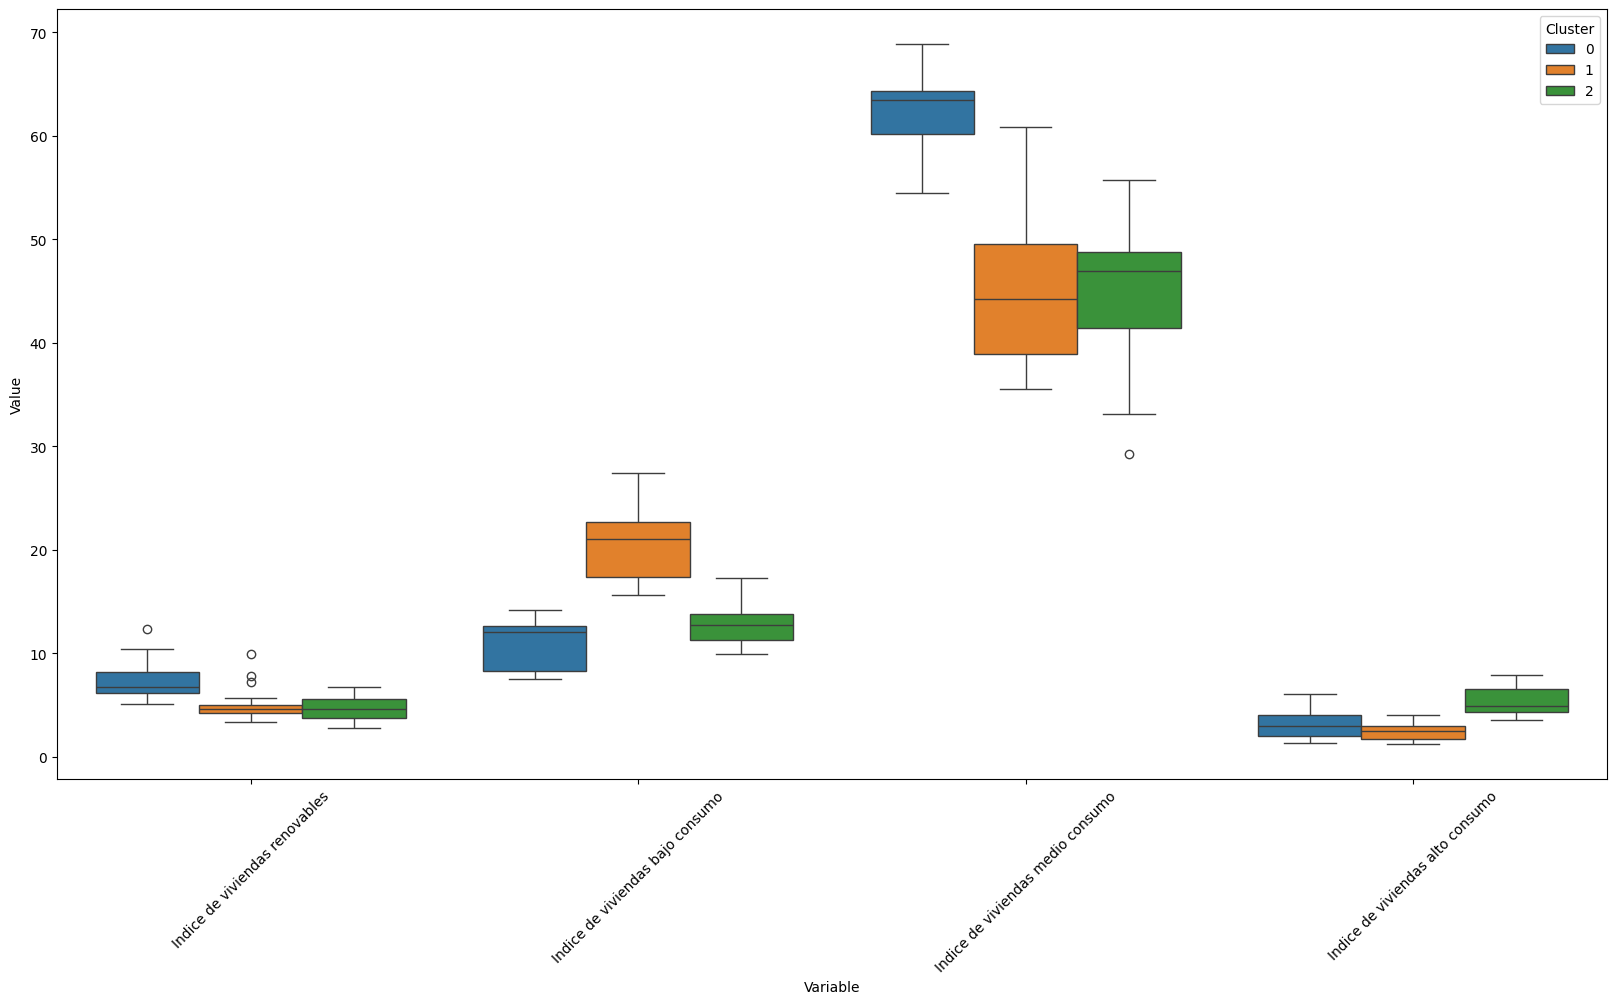

In [100]:
h2_df_melt = h2_df.melt(id_vars=['Provincias', 'Cluster'], var_name='Variable', value_name='Value')
plt.figure(figsize=(20, 10))
sns.boxplot(x='Variable', y='Value', hue='Cluster', data=h2_df_melt)
plt.xticks(rotation=45)
plt.show()


Al interpretar este diagrama para cada grupo se han obtenido las siguientes conclusiones:

##### `Cluster 0`

- **Índice de viviendas renovables**: Respecto a los otros grupos, presenta valores superiores sobre el porcentaje de viviendas con algún dispositivo de energía renovable.

- **Índice de viviendas bajo consumo**: Para esta *feature*, las instancias pertenecientes a este cluster tienen un menor índice de viviendas de bajo consumo.

- **Índice de viviendas medio consumo**: Las provincias que pertenecen a este grupo tienen un porcentaje de viviendas de medio consumo considerablemente superior al resto.

- **Índice de viviendas alto consumo**: Las instancias pertenecientes a este cluster tienen un índice de viviendas de alto consumo cercano a la media nacional.

##### `Cluster 1`

- **Índice de viviendas renovables**: La principal conslusión a la que se puede llegar es que cluster en el que todas las instancias tienen un índice de viviendas renovables bastante similar. Respecto a los otros grupos, presenta valores medios.

- **Índice de viviendas bajo consumo**: Para esta *feature*, las instancias pertenecientes a este cluster tienen un mayor índice de viviendas de bajo consumo.

- **Índice de viviendas medio consumo**: Las provincias que pertenecen a este grupo tienen un porcentaje de viviendas de medio consumo similar a la media nacional aunque los valores para cada una de las instancias están bastante esparcidos.

- **Índice de viviendas alto consumo**: Las instancias pertenecientes a este cluster tienen un índice de viviendas de alto consumo ligeramente inferior a la media nacional.

##### `Cluster 2`

- **Índice de viviendas renovables**: Respecto a los otros grupos, presenta valores medios/bajos sobre el porcentaje de viviendas con algún dispositivo de energía renovable.

- **Índice de viviendas bajo consumo**: Para esta *feature*, las instancias pertenecientes a este cluster tienen un índice de viviendas de bajo consumo intermedio.

- **Índice de viviendas medio consumo**: Las provincias que pertenecen a este grupo presentan una distribución similar a las del **cluster 1**, aunque los valores están más agrupados.

- **Índice de viviendas alto consumo**: Las instancias pertenecientes a este cluster tienen un índice de viviendas de alto consumo superior al resto de grupos.

Una vez entendidos los distintos clusters obtenidos mediante `K-means`, se ha estudiado si es posible validar la hipótesis con los datos obtenidos.

En cuanto al índice de viviendas de medio consumo, si que podemos observar claramente que el cluster con un mayor índice de viviendas de este tipo coincide en ser el cluster con mayor porcentaje de viviendas renovables.

Sin embargo, los clusters con mayor porcentaje de viviendas de bajo y alto consumo, que son el `cluster 1` y el `cluster 2` respectivamente, no nos ofrecen una información tan robusta y significativa como en el caso anterior.

Debido a esto, se ha decidido utilizar otros algoritmos para intentar validar o rechazar la hipótesis planteada.

<hr style="border: none; border-top: 1px solid #ccc;" />

### Regresión

#### Visualización

Inicialmente, se muestra una gráfica que muestra la relación entre el índice de viviendas con algún dispositivo de energía renovable y los índices de viviendas de bajo, medio y alto consumo.

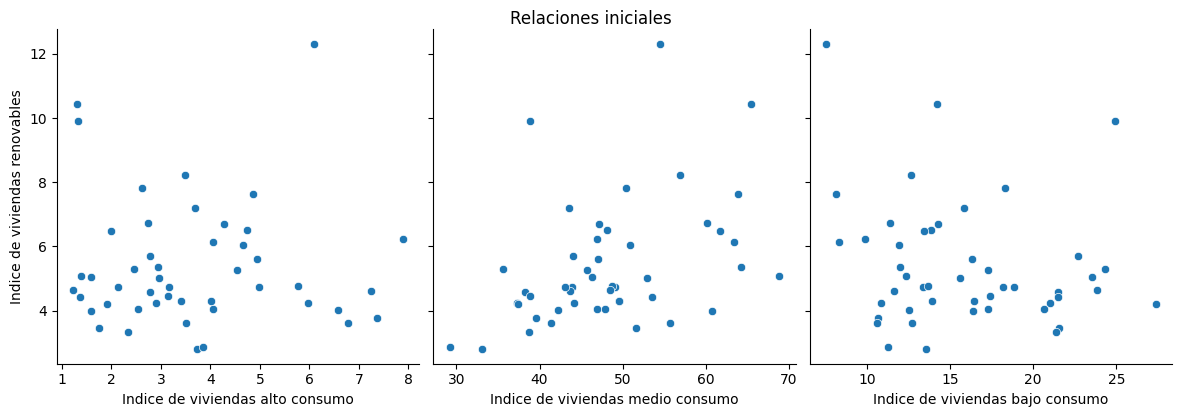

In [101]:
sns.pairplot(h2_df, 
             x_vars=['Indice de viviendas alto consumo', 
                     'Indice de viviendas medio consumo', 
                     'Indice de viviendas bajo consumo'], 
             y_vars='Indice de viviendas renovables', 
             height=4)
plt.suptitle("Relaciones iniciales", y=1.02)
plt.show()


#### Ajuste del modelo de regresión lineal múltiple

A continuación, se ajusta un modelo de regresión lineal múltiple en el que no solo se considera una única *feature* sino se tiene en cuenta el índice de viviendas de bajo, medio y alto consumo.

In [102]:
X = h2_df.drop(columns=['Provincias','Indice de viviendas renovables', 'Cluster'])
y = h2_df['Indice de viviendas renovables']

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [104]:
model.coef_

array([-0.02966921,  0.07551821, -0.01754789])

In [105]:
model.intercept_

np.float64(2.407165101122116)

Los coeficientes obtenidos para cada una de las *features* son los siguientes:

- **Índice de viviendas bajo consumo** = -0.0297

- **Índice de viviendas medio consumo** = 0.0755

- **Índice de viviendas alto consumo** = -0.0175

El valor estimado del intercepto es 2.4072

#### Evaluación del modelo

In [106]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 1.3521236081801606
R² Score: 0.19653536223435997


El error cuadrático medio es bastante bajo para este dominio, ya que, un error del 1% para este caso de estudio no supone un gran problema

Sin embargo, el valor R² obtenido es bastante bajo y nos indica que, a pesar de que haya una relación lineal, es bastante débil.

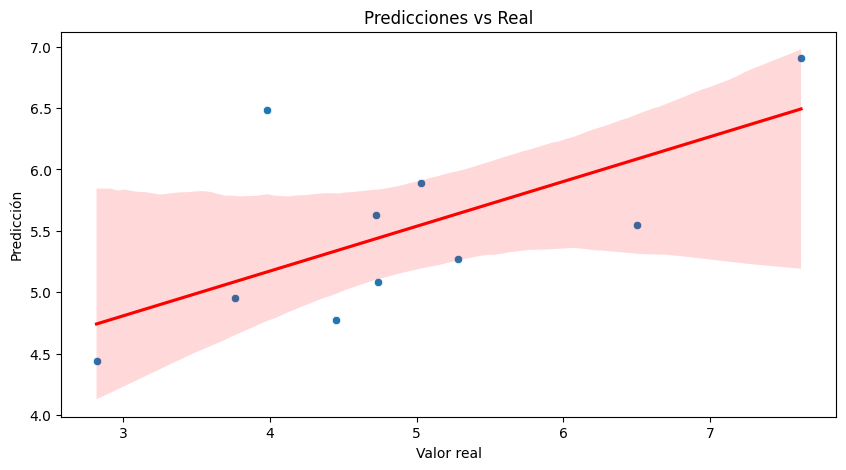

In [107]:
# Plot de las predicciones
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred)
sns.regplot(x=y_test, y=y_pred, scatter=False, color='red',ci=95)
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.title('Predicciones vs Real')
plt.show()

En esta gráfica se intenta representar la precisión del modelo entrenado anteriormente.

La banda roja representa el tamaño del intervalo de confianza para la estimación de la regresión. Para estimar este intervalo, se utilza un bootstrap.

#### Prueba con Cross-Validation

In [108]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import numpy as np

# Crear el modelo
model = LinearRegression()

# Crear los datos (asegúrate de que tu DataFrame tenga X e y definidos)
X = h2_df[['Indice de viviendas alto consumo', 
        'Indice de viviendas medio consumo', 
        'Indice de viviendas bajo consumo']].values
y = h2_df['Indice de viviendas renovables'].values

# Configurar K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas para almacenar resultados
coef_list = []
intercept_list = []
r_square_list = []

# Validación cruzada
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Entrenar el modelo en el pliegue actual
    model.fit(X_train, y_train)
    
    # Guardar coeficientes e intercepto
    coef_list.append(model.coef_)
    intercept_list.append(model.intercept_)

    # Predecir y evaluar
    y_pred = model.predict(X_test)
    r_square = r2_score(y_test, y_pred)
    r_square_list.append(r_square)

# Convertir los resultados a arreglos numpy
coef_array = np.array(coef_list)
intercept_array = np.array(intercept_list)
r_square_array = np.array(r_square_list)

# Mostrar resultados
print("Coeficientes promedio por característica:", np.mean(coef_array, axis=0))
print("Desviación típica de los coeficientes:", np.std(coef_array, axis=0))
print("\nIntercepto promedio:", np.mean(intercept_array))
print("Desviación típica del intercepto:", np.std(intercept_array))
print("\nR² promedio:", np.mean(r_square_array))
print("Desviación típica de R²:", np.std(r_square_array))

Coeficientes promedio por característica: [ 0.05854458  0.08738661 -0.00513734]
Desviación típica de los coeficientes: [0.09837495 0.01873655 0.05487166]

Intercepto promedio: 1.0309944101788582
Desviación típica del intercepto: 1.5630327889764186

R² promedio: -0.09061571484899009
Desviación típica de R²: 0.6685686956906364


Se utiliza **Cross-Validation** para evaluar de manera más robusta y generalizable el modelo. Para ello, se han utilizado 5 subconjuntos aleatorios mediante **KFold**.

A pesar de que los valores y métricas de evaluación obtenidos sean peores que los presentados anteriormente, se considerarán válidos los resultados obtenidos utilizando **Cross-Validation**, ya que esta técnica proporciona una evaluación más confiable y robusta del modelo.

Teniendo en cuenta estos resultados se puede llegar a las siguientes conclusiones:

1. El modelo es muy poco fiable debido a que, al entrenar y evaluar diferentes modelos de **regresión lineal** mediante **cross-validation**, los resultados de los coeficientes y el intercepto varían mucho entre sí (observable en la desviación típica). Además, el R² es bastante bajo y su desviación típica también es bastante alta.

    Esto se puede deber a la poca cantidad de datos con los que se trabaja, provocando que el modelo sea muy dependiente de los datos de entrenamiento utilizados, lo que impide que el modelo consiga generalizar correctamente y obtener resultados consistentes.
    


2. Por cada **17%** (aprox.) que aumente el **índice de viviendas de bajo consumo**, aumenta un 1% el **índice de viviendas renovabes**.


3. Por cada **11,5%** (aprox.) que aumente el **índice de viviendas de medio consumo**, aumenta un 0.087% el **índice de viviendas renovabes**.


4. Por cada **50%** (aprox.) que aumente el **índice de viviendas de alto consumo**, disminuye un 0.25% el **índice de viviendas renovabes**.

#### Observaciones

Quizás sea más coherente y riguroso utilizar una regresión lineal para cada tipo de vivienda, es decir, una regresión para observar el comportamiento de cómo afecta el índice de viviendas que utilizan dispositivos de energía renovable según el índice de viviendas de bajo consumo, otra para las de medio consumo y otra de alto consumo. 

El problema de entrenar un modelo de regresión lineal múltiple es que, las variables `Indice de viviendas de alto consumo` e `Indice de viviendas de bajo consumo`, están altamente correlacionadas (-0.695), por lo que tienen mucho mayor peso que `Indice de viviendas de medio consumo` debido a la multicolinealidad.

Sin embargo, si realizamos una regresión lineal simple para cada una de las variables de estudio, obtendremos resultados menos sesgados y más alineados a la hipótesis que queremos validar.

##### Viviendas de alto consumo

In [109]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import numpy as np

# Crear el modelo
model = LinearRegression()

# Crear los datos (asegúrate de que tu DataFrame tenga X e y definidos)
X = h2_df[['Indice de viviendas alto consumo']].values
y = h2_df['Indice de viviendas renovables'].values

# Configurar K-Fold
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Listas para almacenar resultados
coef_list = []
intercept_list = []
r_square_list = []

# Validación cruzada
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Entrenar el modelo en el pliegue actual
    model.fit(X_train, y_train)
    
    # Guardar coeficientes e intercepto
    coef_list.append(model.coef_)
    intercept_list.append(model.intercept_)
    r_square_list.append(model.score(X_test, y_test))

# Convertir los resultados a arreglos numpy
coef_array = np.array(coef_list)
intercept_array = np.array(intercept_list)

# Mostrar resultados
print("Coeficientes promedio por característica:", np.mean(coef_array, axis=0))
print("Desviación típica de los coeficientes:", np.std(coef_array, axis=0))
print("Intercepto promedio:", np.mean(intercept_array))
print("Desviación típica del intercepto:", np.std(intercept_array))
print("R² promedio:", np.mean(r_square_list))
print("Desviación típica de R²:", np.std(r_square_list))

Coeficientes promedio por característica: [-0.02744394]
Desviación típica de los coeficientes: [0.08349127]
Intercepto promedio: 5.494850988765113
Desviación típica del intercepto: 0.22572997417808338
R² promedio: -0.16868054661100473
Desviación típica de R²: 0.14089876058777395


Teniendo en cuenta estos resultados se puede llegar a las siguientes conclusiones:

1. El modelo es muy poco fiable debido a que, al entrenar y evaluar diferentes modelos de **regresión lineal** mediante **cross-validation**, los resultados de los coeficientes y el intercepto varían mucho entre sí (observable en la desviación típica). Además, el R² es bastante bajo y su desviación típica también es bastante alta.

    Esto se puede deber a la poca cantidad de datos con los que se trabaja, provocando que el modelo sea muy dependiente de los datos de entrenamiento utilizados, lo que impide que el modelo consiga generalizar correctamente y obtener resultados consistentes.
    

2. Por cada **18%** (aprox.) que aumente el **índice de viviendas de alto consumo**, disminuye un **0.5%** el **índice de viviendas renovabes**.

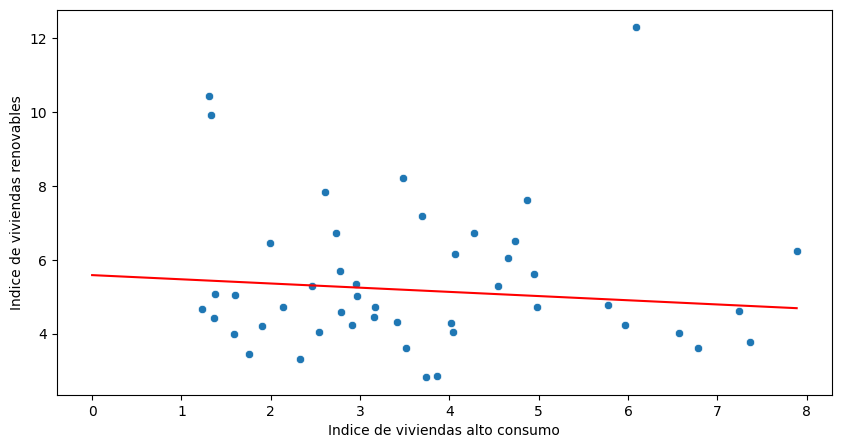

In [110]:
# Grafica de la regresión lineal
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Indice de viviendas alto consumo', y='Indice de viviendas renovables', data=h2_df)

x = np.linspace(0, h2_df["Indice de viviendas alto consumo"].max(), 100)
y = model.coef_[0] * x + model.intercept_
plt.plot(x, y, color='red')

plt.show()

La representación de la regresión lineal obtenida se muestra en la gráfica de arriba. Se puede observar que por la propia naturaleza de los datos, es normal obtener un modelo poco preciso.

##### Viviendas de medio consumo

In [111]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import numpy as np

# Crear el modelo
model = LinearRegression()

# Crear los datos (asegúrate de que tu DataFrame tenga X e y definidos)
X = h2_df[['Indice de viviendas medio consumo']].values
y = h2_df['Indice de viviendas renovables'].values

# Configurar K-Fold
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Listas para almacenar resultados
coef_list = []
intercept_list = []
r_square_list = []

# Validación cruzada
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Entrenar el modelo en el pliegue actual
    model.fit(X_train, y_train)
    
    # Guardar coeficientes e intercepto
    coef_list.append(model.coef_)
    intercept_list.append(model.intercept_)
    r_square_list.append(model.score(X_test, y_test))

# Convertir los resultados a arreglos numpy
coef_array = np.array(coef_list)
intercept_array = np.array(intercept_list)

# Mostrar resultados
print("Coeficientes promedio por característica:", np.mean(coef_array, axis=0))
print("Desviación típica de los coeficientes:", np.std(coef_array, axis=0))
print("Intercepto promedio:", np.mean(intercept_array))
print("Desviación típica del intercepto:", np.std(intercept_array))
print("R² promedio:", np.mean(r_square_list))
print("Desviación típica de R²:", np.std(r_square_list))

Coeficientes promedio por característica: [0.08536784]
Desviación típica de los coeficientes: [0.01885193]
Intercepto promedio: 1.2679755036517835
Desviación típica del intercepto: 1.0168711374645292
R² promedio: 0.10608171090906462
Desviación típica de R²: 0.25666500982677265


Teniendo en cuenta estos resultados se puede llegar a las siguientes conclusiones:

1. El modelo es muy poco fiable debido a que, al entrenar y evaluar diferentes modelos de **regresión lineal** mediante **cross-validation**, los resultados de los coeficientes y el intercepto varían mucho entre sí (observable en la desviación típica). Además, el R² es bastante bajo y su desviación típica también es bastante alta.

    Esto se puede deber a la poca cantidad de datos con los que se trabaja, provocando que el modelo sea muy dependiente de los datos de entrenamiento utilizados, lo que impide que el modelo consiga generalizar correctamente y obtener resultados consistentes.
    

2. Por cada **11.5%** (aprox.) que aumente el **índice de viviendas de alto consumo**, aumenta un **1%** el **índice de viviendas renovabes**.

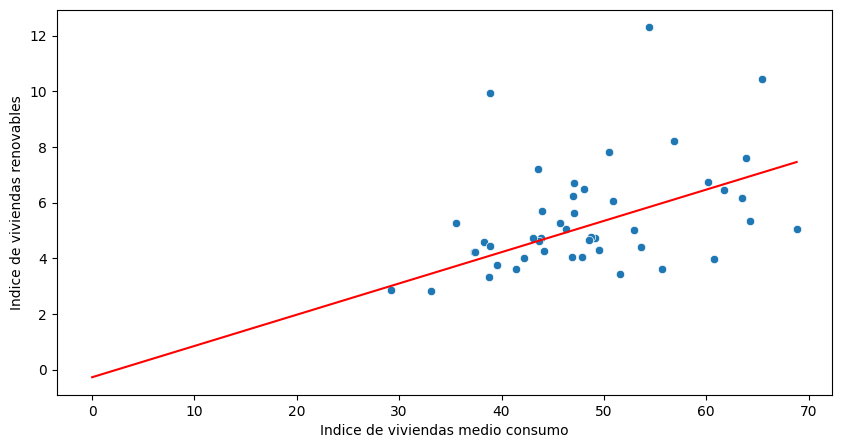

In [112]:
# Grafica de la regresión lineal
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Indice de viviendas medio consumo', y='Indice de viviendas renovables', data=h2_df)

x = np.linspace(0, h2_df["Indice de viviendas medio consumo"].max(), 100)
y = model.coef_[0] * x + model.intercept_
plt.plot(x, y, color='red')

plt.show()

La representación de la regresión lineal obtenida se muestra en la gráfica de arriba. Se puede observar que, en este caso, los datos están mejor agrupados y existe una mayor correlación entre el **índice de viviendas renovables** y el **índice de viviendas de medio consumo**.

##### Viviendas de bajo consumo

In [113]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import numpy as np

# Crear el modelo
model = LinearRegression()

# Crear los datos (asegúrate de que tu DataFrame tenga X e y definidos)
X = h2_df[['Indice de viviendas bajo consumo']].values
y = h2_df['Indice de viviendas renovables'].values

# Configurar K-Fold
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Listas para almacenar resultados
coef_list = []
intercept_list = []
r_square_list = []

# Validación cruzada
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Entrenar el modelo en el pliegue actual
    model.fit(X_train, y_train)
    
    # Guardar coeficientes e intercepto
    coef_list.append(model.coef_)
    intercept_list.append(model.intercept_)
    r_square_list.append(model.score(X_test, y_test))

# Convertir los resultados a arreglos numpy
coef_array = np.array(coef_list)
intercept_array = np.array(intercept_list)

# Mostrar resultados
print("Coeficientes promedio por característica:", np.mean(coef_array, axis=0))
print("Desviación típica de los coeficientes:", np.std(coef_array, axis=0))
print("Intercepto promedio:", np.mean(intercept_array))
print("Desviación típica del intercepto:", np.std(intercept_array))
print("R² promedio:", np.mean(r_square_list))
print("Desviación típica de R²:", np.std(r_square_list))

Coeficientes promedio por característica: [-0.07509406]
Desviación típica de los coeficientes: [0.02137335]
Intercepto promedio: 6.58433410061974
Desviación típica del intercepto: 0.40946622435249996
R² promedio: -0.12687570383396585
Desviación típica de R²: 0.2715004838305934


Teniendo en cuenta estos resultados se puede llegar a las siguientes conclusiones:

1. El modelo es muy poco fiable debido a que, al entrenar y evaluar diferentes modelos de **regresión lineal** mediante **cross-validation**, los resultados de los coeficientes y el intercepto varían mucho entre sí (observable en la desviación típica). Además, el R² es bastante bajo y su desviación típica también es bastante alta.

    Esto se puede deber a la poca cantidad de datos con los que se trabaja, provocando que el modelo sea muy dependiente de los datos de entrenamiento utilizados, lo que impide que el modelo consiga generalizar correctamente y obtener resultados consistentes.
    

2. Por cada **13%** (aprox.) que aumente el **índice de viviendas de alto consumo**, disminuye un **1%** el **índice de viviendas renovabes**.

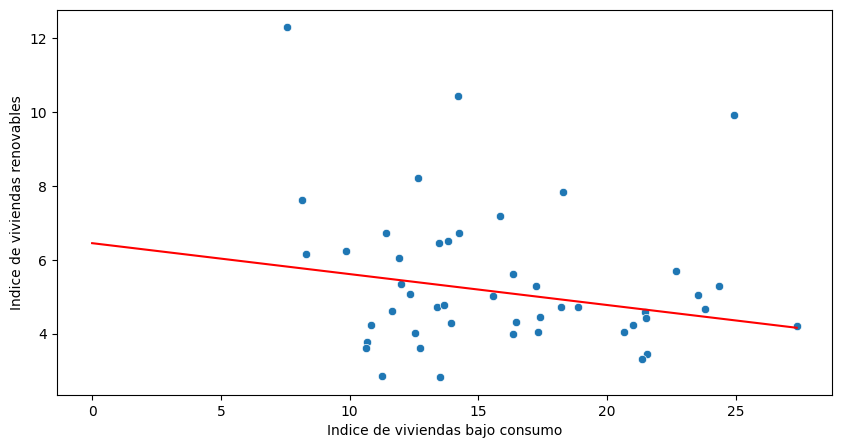

In [114]:
# Grafica de la regresión lineal
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Indice de viviendas bajo consumo', y='Indice de viviendas renovables', data=h2_df)

x = np.linspace(0, h2_df["Indice de viviendas bajo consumo"].max(), 100)
y = model.coef_[0] * x + model.intercept_
plt.plot(x, y, color='red')

plt.show()

La representación de la regresión lineal obtenida se muestra en la gráfica de arriba. Se puede observar que por la propia naturaleza de los datos, es normal obtener un modelo poco preciso.

### Conclusión

A pesar de que los modelos utilizados no sean demasiado precisos, el objetivo de este caso de estudio no es inferir de forma exacta cual sería el índice de viviendas con algún dispositivo renovable de una provincia, sino que, se buscan analizar tendencias.

Se ha concluido que el incremento en el número de viviendas de consumo medio está estrechamente relacionado con un aumento en la cantidad de viviendas equipadas con dispositivos de energía renovable. Por otro lado, un aumento en el índice de viviendas de alto o bajo consumo tiende a reducir el número de hogares con dispositivos de energía renovable, siendo las viviendas de bajo consumo las que generan una disminución más pronunciada.

✅Hipótesis validada.